In [1]:
# !pip install numpy pandas librosa soundfile matplotlib scikit-learn tensorflow==2.15.0 sounddevice==0.4.6

import os, json, math, time, sys, uuid
from dataclasses import dataclass
from typing import Optional, Tuple, List
from pathlib import Path


import numpy as np
import pandas as pd
import soundfile as sf
import librosa

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from IPython.display import Audio, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Global configuration

CSV_PATH = "../../../data/labels_export.csv"   # adjust this to your own path

# ROOT_AUDIO now points to a list of folders to search for audio files
ROOT_AUDIO = ["../../../data/coughing/", "../../../data/heartsounds/"]

# audio / feature parameters
TARGET_SR: int = 15750                 # your recordings are 15750/16000 → resample to 15750
FRAME_LEN_S: float = 3.0               # fixed duration per sample (pad/crop)
N_FFT: int = 1024
HOP: int = 256
WIN: int = 1024                        # same as N_FFT (Hann)
FMIN: int = 20
FMAX: Optional[int] = None             # None → use sr/2
TOP_DB: float = 80.0                   # for visualization / normalization

# derived dimensions (no centering so shapes remain deterministic)
FRAME_LEN_SAMPLES = int(round(FRAME_LEN_S * TARGET_SR))
F_BINS = 1 + N_FFT // 2
T_BINS = 1 + max(0, (FRAME_LEN_SAMPLES - N_FFT)) // HOP

print("Expected STFT shape (F, T):", F_BINS, T_BINS)


Expected STFT shape (F, T): 513 181


In [3]:
df = pd.read_csv(CSV_PATH)
print(df.head(3))
print("\nKolommen:", list(df.columns))

         date                             filename  t_start  t_end  label  \
0  2025-10-09  coughing/new_microphone/cough_1.wav     6.91   9.91  Hoest   
1  2025-10-09  coughing/new_microphone/cough_1.wav    11.93  14.93  Hoest   
2  2025-10-09  coughing/new_microphone/cough_1.wav    16.77  19.77  Hoest   

  gender  age  location  
0    NaN  NaN       NaN  
1    NaN  NaN       NaN  
2    NaN  NaN       NaN  

Kolommen: ['date', 'filename', 't_start', 't_end', 'label', 'gender', 'age', 'location']


In [4]:
# Derive a primary label: take the first token (split on ';') and trim whitespace
def to_primary_label(s: str) -> str:
    # If the value is not a string or is empty → return a safe fallback
    if not isinstance(s, str) or s.strip() == "":
        return "Unknown"
    # Take the first part before ';' and strip spaces
    tok = s.split(";")[0].strip()
    return tok if tok else "Unknown"

# Apply the primary-label extraction to the 'label' column
df["label_primary"] = df["label"].apply(to_primary_label)

# Note: if your dataset still uses Dutch labels, keep "Hoest", "Normaal", "Hart".
keep = df["label_primary"].isin(["Hoest", "Normaal", "Hart"])
df = df[keep].reset_index(drop=True)

# Quick sanity checks: class counts and total number of rows kept
print(df["label_primary"].value_counts())
print(len(df), "segment rows")

label_primary
Hart       200
Normaal    116
Hoest       56
Name: count, dtype: int64
372 segment rows


In [ ]:
# Assumes ROOT_AUDIO, FRAME_LEN_S, FRAME_LEN_SAMPLES, N_FFT, HOP, WIN, TOP_DB, T_BINS exist in the notebook

def load_audio_full(rel_path: str, target_sr: int) -> np.ndarray:
    """
    Load a WAV file (mono) and resample to target_sr.
    Works when ROOT_AUDIO is either a str or a list of root folders.
    """
    import os  # local import to keep function self-contained

    # 1) If rel_path is already an absolute, existing path → use it directly
    p = Path(rel_path)
    if p.is_absolute() and p.exists():
        path = str(p)
    else:
        # 2) Otherwise, search under ROOT_AUDIO
        if isinstance(ROOT_AUDIO, (list, tuple)):
            path = None
            rel_p = Path(rel_path)
            rel_parts = rel_p.parts

            for root in ROOT_AUDIO:
                root_p = Path(root)

                # (a) Try root / rel_path (the most direct mapping)
                cand = root_p / rel_p
                if cand.exists():
                    path = str(cand)
                    break

                # (b) If the first folder in rel matches the last folder of root (e.g., 'coughing'),
                #     try dropping that first rel component to avoid 'coughing/coughing/...'
                if rel_parts and root_p.name == rel_parts[0]:
                    cand2 = root_p / Path(*rel_parts[1:])
                    if cand2.exists():
                        path = str(cand2)
                        break

                # (c) Also try the parent of root combined with rel_path (e.g., ../data/ + rel_path)
                cand3 = root_p.parent / rel_p
                if cand3.exists():
                    path = str(cand3)
                    break

                # (d) Fallback: just the filename inside root
                cand4 = root_p / rel_p.name
                if cand4.exists():
                    path = str(cand4)
                    break

            if path is None:
                raise FileNotFoundError(f"File not found for '{rel_path}' in ROOT_AUDIO={ROOT_AUDIO}")

    # Read audio; convert to mono by averaging channels if needed
    y, sr = sf.read(path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)

    # Resample if the file's sample rate differs from target_sr
    if sr != target_sr:
        # Simple band-limited up/downsampling via linear interpolation (no extra deps)
        n_new = int(round(len(y) * float(target_sr) / float(sr)))
        if n_new <= 1 or len(y) <= 1:
            y = np.zeros(max(n_new, 1), dtype=np.float32)
        else:
            x_old = np.arange(len(y), dtype=np.float64)
            x_new = np.linspace(0.0, len(y) - 1.0, n_new, dtype=np.float64)
            y = np.interp(x_new, x_old, y).astype(np.float32)
        sr = target_sr

    return y


def fix_segment_bounds(t0: float, t1: float, dur: float,
                       frame_len_s: float, tol: float = 1e-3) -> Tuple[float, float]:
    """
    Ensure each segment has exactly 'frame_len_s' duration.

    - If (t1 - t0) ≈ frame_len_s → OK (snap to 2 decimals).
    - If shorter/longer: force exact length by setting end = start + frame_len_s,
      and shift left if we would exceed the file duration.
    """
    t0 = float(t0)
    t1 = float(t1)
    want = float(frame_len_s)
    have = t1 - t0

    # Close enough → snap to 2 decimals within valid range
    if abs(have - want) <= tol:
        a = round(max(0.0, min(t0, max(0.0, dur - want))), 2)
        b = round(min(dur, a + want), 2)
        return a, b

    # Otherwise, make it exactly frame_len_s, shifting left if needed
    a = t0
    b = a + want
    if b > dur:
        a = max(0.0, dur - want)
        b = a + want
    return round(a, 2), round(b, 2)


def load_audio_segment(rel_path: str, t0: float, t1: float,
                       target_sr: int, ensure_len: bool = True) -> np.ndarray:
    """
    Cut segment [t0, t1) from file and resample.
    Pad or crop to FRAME_LEN_SAMPLES if required.
    """
    # Load the full audio at target_sr
    y_full = load_audio_full(rel_path, target_sr)
    dur = len(y_full) / target_sr

    # Optionally adjust (t0, t1) to be exactly FRAME_LEN_S long
    if ensure_len:
        t0, t1 = fix_segment_bounds(t0, t1, dur, FRAME_LEN_S)

    # Convert times to sample indices and clamp to valid bounds
    a = int(round(t0 * target_sr))
    b = int(round(t1 * target_sr))
    a = max(0, min(a, len(y_full)))
    b = max(0, min(b, len(y_full)))
    y = y_full[a:b]

    # Pad/crop to the exact target length in samples
    if len(y) < FRAME_LEN_SAMPLES:
        y = np.pad(y, (0, FRAME_LEN_SAMPLES - len(y)))
    elif len(y) > FRAME_LEN_SAMPLES:
        y = y[:FRAME_LEN_SAMPLES]

    return y.astype(np.float32)


def pre_emphasis(y: np.ndarray, coef: float = 0.97) -> np.ndarray:
    """
    Simple pre-emphasis filter (light noise suppression / emphasize HF detail).
    """
    if len(y) < 2:
        return y
    out = np.empty_like(y)
    out[0] = y[0]
    out[1:] = y[1:] - coef * y[:-1]
    return out


def compute_stft_db(y: np.ndarray, sr: int, n_fft: int = N_FFT, hop: int = HOP,
                    win: int = WIN, center: bool = False) -> np.ndarray:
    """
    |Y| in dB with max = 0 dB (normalized per segment).
    Output shape: (F_BINS, T) where F_BINS = 1 + n_fft // 2.
    """
    # Optional denoise step: pre-emphasis improves high-frequency detail
    y = pre_emphasis(y)

    # STFT (no centering by default to keep shapes deterministic elsewhere)
    S = librosa.stft(
        y, n_fft=n_fft, hop_length=hop, win_length=win,
        window="hann", center=center
    )
    mag = np.abs(S).astype(np.float32)

    # Normalize magnitude so max == 1 per segment
    mmax = mag.max() if mag.size else 1.0
    if mmax <= 1e-12:
        mmax = 1.0
    mag = mag / mmax

    # Convert to dB; guard against log(0)
    S_db = 20.0 * np.log10(np.maximum(mag, 1e-6))  # in [-120, 0]
    return S_db


def fix_time_bins_stft(S_db: np.ndarray, t_bins: int = T_BINS) -> np.ndarray:
    """
    Pad or crop the time axis of the STFT (in dB) to exactly t_bins frames.
    """
    F, T = S_db.shape
    if T < t_bins:
        # Right-pad with very low dB values
        pad = np.full((F, t_bins - T), -120.0, dtype=np.float32)
        S_db = np.concatenate([S_db, pad], axis=1)
    elif T > t_bins:
        # Crop extra frames
        S_db = S_db[:, :t_bins]
    return S_db


def spectrogram_to_01(S_db: np.ndarray, top_db: float = TOP_DB) -> np.ndarray:
    """
    Map dB range [-top_db, 0] → [0, 1].
    Anything below -top_db is clipped to 0.
    """
    S_clipped = np.clip(S_db, -top_db, 0.0)
    return (S_clipped + top_db) / top_db

In [6]:
# Check and fix segment lengths if needed; print how many were adjusted
def check_and_fix_lengths(df_segments: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure each row's [t_start, t_end) matches FRAME_LEN_S (seconds).
    If needed, adjust using fix_segment_bounds and count how many were changed.
    """
    fixed = 0
    rows = []
    for _, row in df_segments.iterrows():
        rel = row["filename"]
        # Compute total duration (seconds) after loading/resampling to TARGET_SR
        dur_s = len(load_audio_full(rel, TARGET_SR)) / TARGET_SR

        # Original boundaries
        a, b = float(row["t_start"]), float(row["t_end"])

        # Correct boundaries to exactly FRAME_LEN_S (snap left if exceeding file end)
        a2, b2 = fix_segment_bounds(a, b, dur_s, FRAME_LEN_S)

        # Count if anything changed or if length was off
        if abs((b - a) - FRAME_LEN_S) > 1e-3 or abs(a - a2) > 1e-6 or abs(b - b2) > 1e-6:
            fixed += 1

        # Store updated row
        r = row.copy()
        r["t_start"] = a2
        r["t_end"]   = b2
        rows.append(r)

    print(f"Segments fixed/normalized: {fixed} / {len(df_segments)}")
    return pd.DataFrame(rows)


# Create a corrected copy of the segments table
df_segments = check_and_fix_lengths(df.copy())
df_segments.head(3)

Segments fixed/normalized: 46 / 372


,date,filename,t_start,t_end,label,gender,age,location,label_primary
0,2025-10-09,coughing/new_microphone/cough_1.wav,6.91,9.91,Hoest,NaN,NaN,NaN,Hoest
1,2025-10-09,coughing/new_microphone/cough_1.wav,11.93,14.93,Hoest,NaN,NaN,NaN,Hoest
2,2025-10-09,coughing/new_microphone/cough_1.wav,16.77,19.77,Hoest,NaN,NaN,NaN,Hoest


In [7]:
df_segments = df_segments.drop(columns=["gender", "age", "location"])
df_segments.head(3)

,date,filename,t_start,t_end,label,label_primary
0,2025-10-09,coughing/new_microphone/cough_1.wav,6.91,9.91,Hoest,Hoest
1,2025-10-09,coughing/new_microphone/cough_1.wav,11.93,14.93,Hoest,Hoest
2,2025-10-09,coughing/new_microphone/cough_1.wav,16.77,19.77,Hoest,Hoest


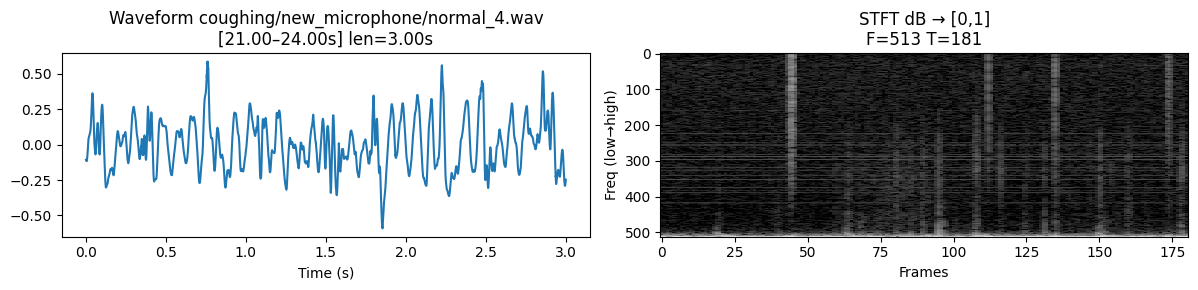

In [8]:
# Simple preview function for a random segment
def preview_segment(row, sr: int = TARGET_SR):
    """
    Preview a single segment:
    - load the audio segment
    - show waveform and STFT→[0,1] image
    - play back audio
    """
    rel = row["filename"]
    a, b = float(row["t_start"]), float(row["t_end"])

    # Load the exact segment at the target sample rate
    y = load_audio_segment(rel, a, b, sr)

    # Plot waveform
    t = np.arange(len(y)) / sr
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(t, y)
    ax[0].set_title(f"Waveform {rel}\n[{a:.2f}–{b:.2f}s] len={len(y)/sr:.2f}s")
    ax[0].set_xlabel("Time (s)")

    # STFT → dB → fixed time bins → map to [0,1]
    S_db = compute_stft_db(y, sr, N_FFT, HOP, WIN, center=False)
    S_db = fix_time_bins_stft(S_db, T_BINS)
    img = spectrogram_to_01(S_db, TOP_DB)

    # Show spectrogram image (flip vertically so low→high bottom→top becomes top→bottom)
    ax[1].imshow(img[::-1, :], aspect="auto", interpolation="nearest", cmap="gray")
    ax[1].set_title(f"STFT dB → [0,1]\nF={img.shape[0]} T={img.shape[1]}")
    ax[1].set_xlabel("Frames")
    ax[1].set_ylabel("Freq (low→high)")

    plt.tight_layout()
    plt.show()

    # Playback
    display(Audio(y, rate=sr))


# Pick a random segment and preview it
preview_segment(df_segments.sample(1, random_state=1).iloc[0])

In [9]:
# 1) Label normalization (so variants like 'cough', 'normal', 'heart' also work)
def _norm_label(x: str) -> str:
    """
    Normalize common label variants to a unified set:
    'Hoest' (Cough), 'Normaal' (Normal), 'Hart' (Heart).

    Notes
    -----
    - Keeps Dutch canonical labels to match your dataset.
    - Any unknown/other value is returned as-is (you may want to log a warning).
    """
    x = str(x).strip().lower()
    if x in {"hoest", "cough"}:
        return "Hoest"
    if x in {"normaal", "normal"}:
        return "Normaal"
    if x in {"hart", "heart"}:
        return "Hart"
    return x  # leave as-is (consider warning/logging if unexpected)

# Apply normalization to the primary label column
df_segments = df.copy()
df_segments["label_primary_norm"] = df_segments["label_primary"].map(_norm_label)

In [10]:
df_segments['label_primary_norm'].value_counts()

label_primary_norm
Hart       200
Normaal    116
Hoest       56
Name: count, dtype: int64

In [11]:
# 2) Define the three binary experiments
# Each tuple: (human-readable name, (class_a, class_b))
experiments = [
    ("Hoest vs Normaal", ("Hoest", "Normaal")),
    ("Hoest vs Hart",    ("Hoest", "Hart")),
    ("Normaal vs Hart",  ("Normaal", "Hart")),
]

In [12]:
# Input shape for spectrogram-like tensors (F, T, 1)
input_shape = (F_BINS, T_BINS, 1)

def build_cnn(num_classes: int) -> keras.Model:
    """
    Build and compile a small CNN for (F, T, 1) inputs.

    Parameters
    ----------
    num_classes : int
        Number of output classes (2 for binary tasks).

    Returns
    -------
    keras.Model
        Compiled model with Adam optimizer and accuracy metric.
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [13]:
# 4) Reusable training/evaluation per experiment
def run_experiment(title: str, classes_pair: tuple[str, str]):
    """
    Train and evaluate a small CNN for a given binary class pair.

    Steps:
      1) Filter the dataset to the two requested classes
      2) Encode the labels (LabelEncoder on exactly these two classes)
      3) Build inputs (audio -> STFT dB -> fixed time bins -> [0,1] image)
      4) Group-wise split by filename (train/val = 80/20)
      5) Train with simple callbacks
      6) Plot training curves and show confusion matrix + report
    """
    input_shape = (F_BINS, T_BINS, 1)
    cls_a, cls_b = classes_pair

    print("\n" + "=" * 80)
    print(f"EXPERIMENT: {title}  —  Classes: {cls_a} vs {cls_b}")

    # Keep only the two desired classes
    df_bin = df_segments[df_segments["label_primary_norm"].isin(classes_pair)].copy()
    if df_bin.empty:
        print("No data for this class combination; skipping.")
        return

    # Fit a LabelEncoder on exactly these two classes (order preserved)
    le = LabelEncoder()
    le.fit(list(classes_pair))
    df_bin["y"] = le.transform(df_bin["label_primary_norm"])
    class_names = list(le.classes_)
    n_classes = len(class_names)
    print("Classes (encoded):", class_names)

    # Build X, y, and grouping keys (group by filename to avoid leakage)
    X_list, y_list, groups = [], [], []
    for _, row in df_bin.iterrows():
        rel = row["filename"]
        a, b = float(row["t_start"]), float(row["t_end"])

        # Audio segment -> STFT (dB) -> fix time bins -> map to [0,1] -> add channel dim
        y_seg = load_audio_segment(rel, a, b, TARGET_SR)
        S_db  = compute_stft_db(y_seg, TARGET_SR, N_FFT, HOP, WIN, center=False)
        S_db  = fix_time_bins_stft(S_db, T_BINS)
        X_list.append(spectrogram_to_01(S_db, TOP_DB)[..., None].astype(np.float32))
        y_list.append(int(row["y"]))
        groups.append(rel)  # group by file

    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    groups = np.array(groups)
    print("X shape:", X.shape, "y shape:", y.shape)

    # Group-wise split by filename: 80/20
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    (train_idx, val_idx), = gss.split(X, y, groups=groups)
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]

    print("Train:", X_train.shape, "Val:", X_val.shape)
    print("Class balance (train):", np.bincount(y_train, minlength=n_classes))
    print("Class balance (val)  :", np.bincount(y_val,   minlength=n_classes))

    # Model
    model = build_cnn(n_classes)

    # Simple callbacks: ReduceLROnPlateau + EarlyStopping
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    ]

    # Train
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Accuracy curve
    plt.figure(figsize=(10, 3))
    plt.plot(hist.history["accuracy"], label="acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.legend()
    plt.title(f"{title} — Accuracy")
    plt.show()

    # Loss curve
    plt.figure(figsize=(10, 3))
    plt.plot(hist.history["loss"], label="loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.legend()
    plt.title(f"{title} — Loss")
    plt.show()

    # Evaluation on validation set
    y_pred = model.predict(X_val, batch_size=64).argmax(axis=1)
    cm = confusion_matrix(y_val, y_pred, labels=list(range(n_classes)))
    print(classification_report(y_val, y_pred, target_names=class_names, digits=3))

    # Confusion matrix plot
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(n_classes), class_names, rotation=45, ha="right")
    plt.yticks(range(n_classes), class_names)
    for i in range(n_classes):
        for j in range(n_classes):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()


EXPERIMENT: Hoest vs Normaal  —  Classes: Hoest vs Normaal
Classes (encoded): [np.str_('Hoest'), np.str_('Normaal')]
X shape: (172, 513, 181, 1) y shape: (172,)
Train: (130, 513, 181, 1) Val: (42, 513, 181, 1)
Class balance (train): [40 90]
Class balance (val)  : [16 26]
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.5538 - loss: 10.4338 - val_accuracy: 0.9524 - val_loss: 0.0841 - learning_rate: 0.0010
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.8231 - loss: 1.3185 - val_accuracy: 0.9286 - val_loss: 0.1287 - learning_rate: 0.0010
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.8923 - loss: 0.3972 - val_accuracy: 0.8810 - val_loss: 0.1768 - learning_rate: 0.0010
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8338 - loss: 0.3660
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.8615 - loss: 0.3376 - val_accuracy: 1.0000 - val_loss: 0.1175 -

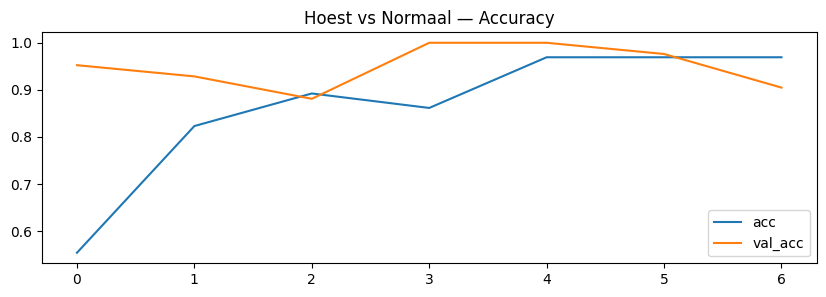

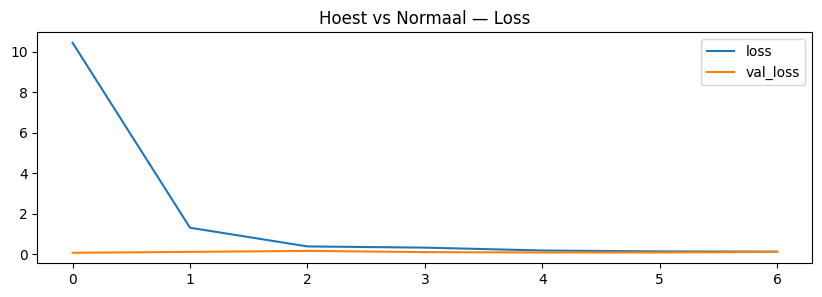

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
              precision    recall  f1-score   support

       Hoest      1.000     0.875     0.933        16
     Normaal      0.929     1.000     0.963        26

    accuracy                          0.952        42
   macro avg      0.964     0.938     0.948        42
weighted avg      0.956     0.952     0.952        42



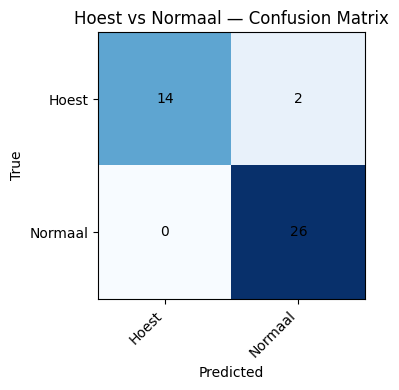


EXPERIMENT: Hoest vs Hart  —  Classes: Hoest vs Hart
Classes (encoded): [np.str_('Hart'), np.str_('Hoest')]
X shape: (256, 513, 181, 1) y shape: (256,)
Train: (196, 513, 181, 1) Val: (60, 513, 181, 1)
Class balance (train): [150  46]
Class balance (val)  : [50 10]
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.7245 - loss: 4.1270 - val_accuracy: 0.9167 - val_loss: 0.2974 - learning_rate: 0.0010
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.8776 - loss: 0.5549 - val_accuracy: 1.0000 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9541 - loss: 0.1210 - val_accuracy: 0.9333 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.9898 - loss: 0.0848 - val_accuracy: 0.9833 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9898 - loss: 0.0509 - val_accuracy: 1.0000 - val_loss: 0.0211 - learni

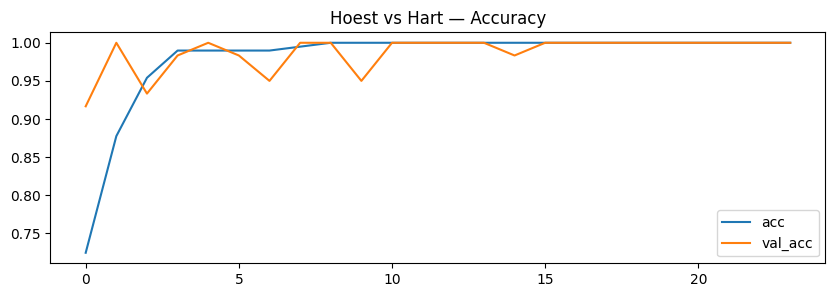

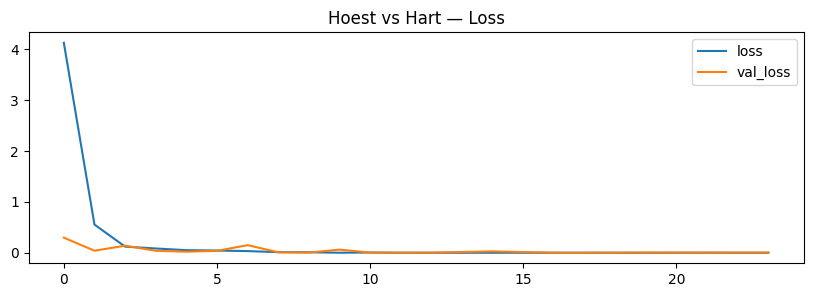

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
              precision    recall  f1-score   support

        Hart      1.000     1.000     1.000        50
       Hoest      1.000     1.000     1.000        10

    accuracy                          1.000        60
   macro avg      1.000     1.000     1.000        60
weighted avg      1.000     1.000     1.000        60



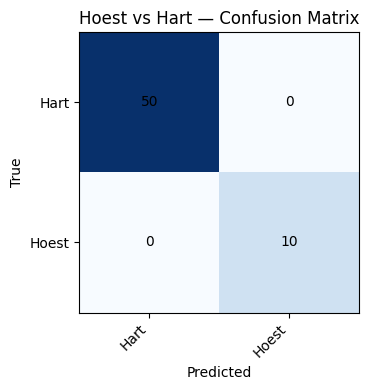


EXPERIMENT: Normaal vs Hart  —  Classes: Normaal vs Hart
Classes (encoded): [np.str_('Hart'), np.str_('Normaal')]
X shape: (316, 513, 181, 1) y shape: (316,)
Train: (242, 513, 181, 1) Val: (74, 513, 181, 1)
Class balance (train): [150  92]
Class balance (val)  : [50 24]
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.5207 - loss: 6.1881 - val_accuracy: 0.3243 - val_loss: 5.4801 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.5579 - loss: 1.8165 - val_accuracy: 0.6757 - val_loss: 0.8524 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.6570 - loss: 0.6538 - val_accuracy: 0.4730 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.6570 - loss: 0.5470 - val_accuracy: 0.8649 - val_loss: 0.5280 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.8223 - loss: 0.4207 - val_accuracy: 0.8378 - val_loss: 0.4289 - 

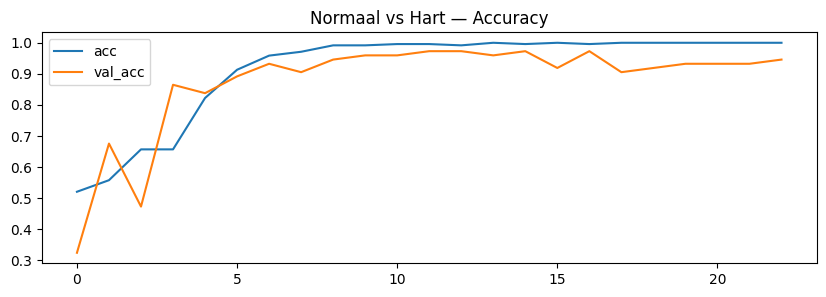

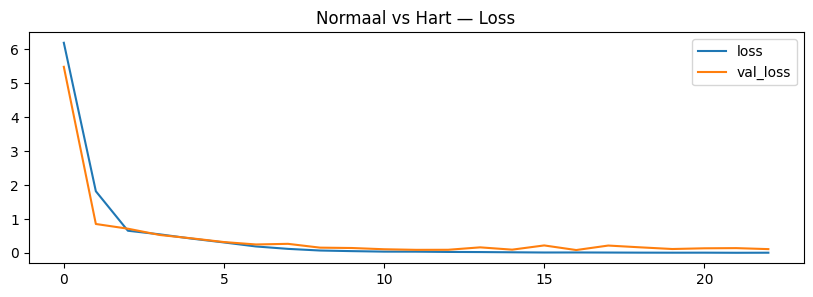

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
              precision    recall  f1-score   support

        Hart      1.000     0.960     0.980        50
     Normaal      0.923     1.000     0.960        24

    accuracy                          0.973        74
   macro avg      0.962     0.980     0.970        74
weighted avg      0.975     0.973     0.973        74



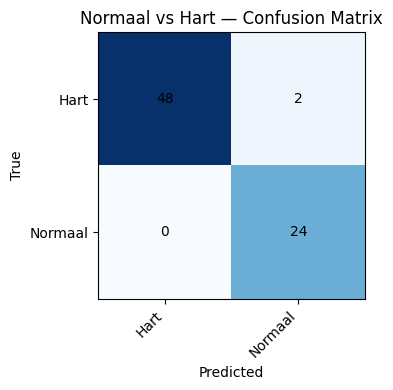

In [14]:
# 5) Run all experiments
for exp_title, pair in experiments:
    run_experiment(exp_title, pair)